# Training Sentence Similarity

Skyeler McQueen

skyelerm@umich.edu

In this file, I will be training a sentence transformer on the paired data (sbertdata.csv). The script that I used to actually train the model via Great Lakes is titled 'sentsim.py'.

In [33]:
from sentence_transformers import SentenceTransformer, models,losses, evaluation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from sentence_transformers import evaluation
from sentence_transformers.util import cos_sim
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
palette = ['#F84AA7','#03256C','#F3CA40','#FF3562','#F2A541']
sns.set_palette(palette)

Read in the data and split into testing, training, and dev. Training is 70% of the data, test 20%, and dev 10%.

In [19]:
data = pd.read_csv('sbertdata.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

train_df, other_df = train_test_split(data, test_size=.3, random_state=13,stratify=data['similarity'])

test_df, dev_df = train_test_split(other_df, test_size=.333,random_state=13,stratify=other_df['similarity'])

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
dev_df.dropna(inplace=True)

Initialize the model.

In [20]:
word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


Format the training data.

In [4]:
train_examples = []
for index, row in train_df.iterrows():
    ex = InputExample(texts=[row['quote_x'], row['quote_y']], label=float(row['similarity']))
    train_examples.append(ex)


train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

Format the development data.

In [5]:
dev_examples = []
for index, row in dev_df.iterrows():
    ex = InputExample(texts=[row['quote_x'], row['quote_y']], label=float(row['similarity']))
    dev_examples.append(ex)

dev_dataloader = DataLoader(dev_examples, shuffle=True, batch_size=16)

Initialize the loss and evaluator.

In [17]:
train_loss = losses.CosineSimilarityLoss(model)

In [22]:
evaluator = evaluation.EmbeddingSimilarityEvaluator(list(dev_df['quote_x']),list(dev_df['quote_y']),[float(x) for x in list(dev_df['similarity'])])

Train the model!

In [10]:
model.fit(train_objectives=[
          (train_dataloader, train_loss)], epochs=5, warmup_steps=100, evaluator=evaluator,save_best_model=True,checkpoint_save_total_limit=5,evaluation_steps=50)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

: 

Save the model.

In [43]:
model.save('sentsimmodel')

## Evaluation

Now I want to evaluate the model. I ran for 1 epoch ('sentsimmodel') and then for 5 ('sentsimmodel_eval') and 10 epochs ('sentsimmodel_10').

Load up the model!

In [21]:
model1 = SentenceTransformer('sentsimmodel')
model2 = SentenceTransformer('sentsimmodel_eval')

In [40]:
model3 = SentenceTransformer('sentsimmodel_7')

In [49]:
model4 = SentenceTransformer('roberta_1')
model5 = SentenceTransformer('roberta_5')

In [56]:
model6 = SentenceTransformer('roberta_7')

In [22]:
def apply_model(row:pd.Series,model:SentenceTransformer)->int:
    '''This function applies the model to two sentences.

    Keyword arguments:
    row -- pd.Series, a row of a data frame with columns 'quote_x' and 'quote_y'.
    model -- SentenceTransformer, a model!
    '''
    x = model.encode(row['quote_x'])
    y = model.encode(row['quote_y'])
    sim = cos_sim(x,y)
    return sim

Apply it to the test data.

In [24]:
test_df['model1']=test_df.apply(apply_model,args=[model1],axis=1)
test_df['model2']=test_df.apply(apply_model,args=[model2],axis=1)

In [41]:
test_df['model3']=test_df.apply(apply_model,args=[model3],axis=1)

In [50]:
test_df['model4']=test_df.apply(apply_model,args=[model4],axis=1)
test_df['model5']=test_df.apply(apply_model,args=[model5],axis=1)

/Users/Skyeler/anaconda3/envs/si649f23/lib/python3.11/site-packages/transformers/models/roberta/modeling_roberta.py:1561: UserWarning: cumsum_out_mps supported by MPS on MacOS 13+, please upgrade (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/UnaryOps.mm:406.)
  incremental_indices = (torch.cumsum(mask, dim=1).type_as(mask) + past_key_values_length) * mask


In [57]:
test_df['model6']=test_df.apply(apply_model,args=[model6],axis=1)

Now I want to find out what threshold we should use. Rounding will likely give a less optimal F1 score, which I will show later. I will find the threshold by seeing what value maximizes the dev F1. 

In [25]:
dev_df['model1']=dev_df.apply(apply_model,args=[model1],axis=1)
dev_df['model2']=dev_df.apply(apply_model,args=[model2],axis=1)

In [42]:
dev_df['model3']=dev_df.apply(apply_model,args=[model3],axis=1)

In [51]:
dev_df['model4']=dev_df.apply(apply_model,args=[model4],axis=1)
dev_df['model5']=dev_df.apply(apply_model,args=[model5],axis=1)

In [58]:
dev_df['model6']=dev_df.apply(apply_model,args=[model6],axis=1)

In [26]:
def find_best_thres(col_name):
    thres_f1 = {}
    for x in range(-10000,10000):
        threshold = x/10000
        temp = dev_df[col_name].apply(lambda x: 1 if x >= threshold else 0)
        f1 =f1_score(dev_df['similarity'], temp)
        thres_f1[threshold]=f1
        

    plot = sns.lineplot(x=list(thres_f1.keys()),y=list(thres_f1.values()))
    plot.set_xlabel('Threshold Value')
    plot.set_ylabel('F1 Score')
    plot.set_title('Threshold Values and Dev F1 Scores')

    max_threshold = max(thres_f1, key=thres_f1.get)
    print('Threshold: ',max_threshold)
    print('F1 Score: ',thres_f1[max_threshold])
    return(max_threshold)

Threshold:  0.1449
F1 Score:  0.3015632879475542
Threshold:  0.2178
F1 Score:  0.3081570996978852


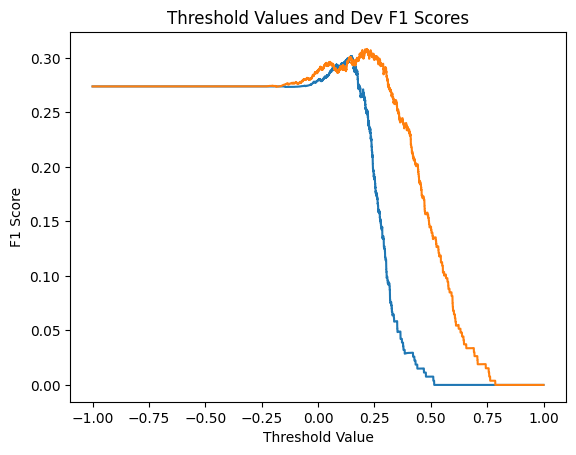

In [27]:
model1_thres = find_best_thres('model1')
model2_thres = find_best_thres('model2')

Threshold:  0.1128
F1 Score:  0.3101391650099403


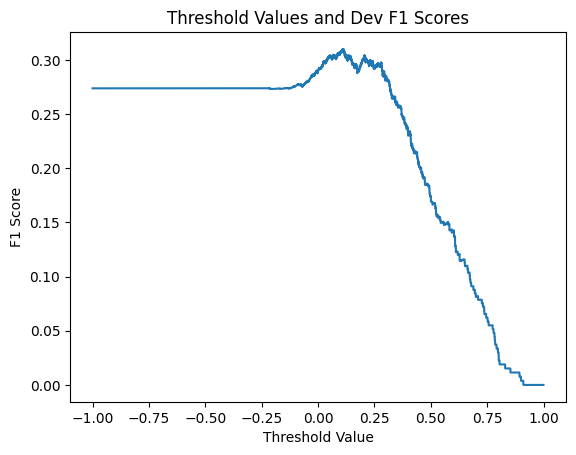

In [43]:
model3_thres = find_best_thres('model3')

Threshold:  0.0819
F1 Score:  0.2867898699520876
Threshold:  0.0859
F1 Score:  0.2996575342465753


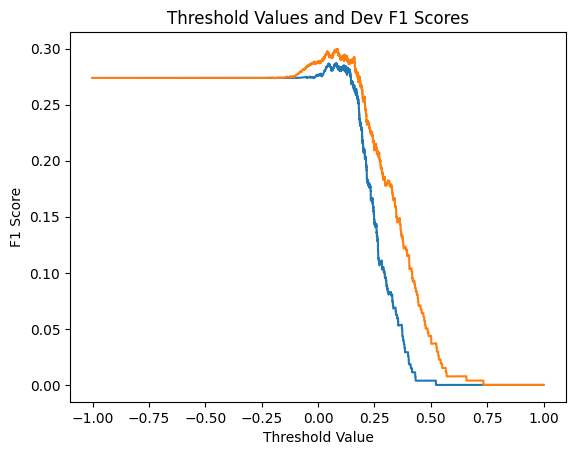

In [59]:
model4_thres = find_best_thres('model4')
model5_thres = find_best_thres('model5')

Threshold:  0.1314
F1 Score:  0.3050847457627119


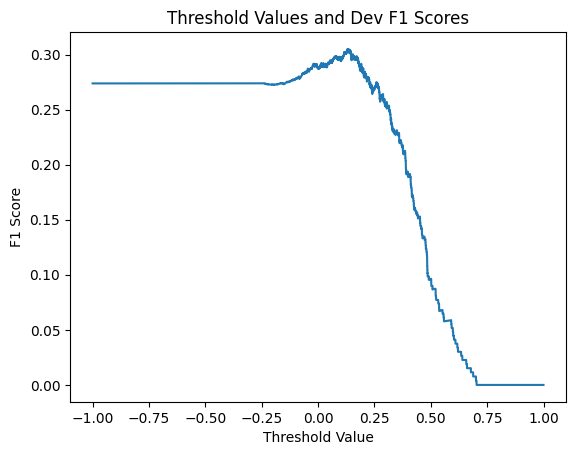

In [60]:
model6_thres = find_best_thres('model6')

In [62]:
test_df['thres_pred1']=test_df['model1'].apply(lambda x: 1 if x >= model1_thres else 0)
test_df['thres_pred2']=test_df['model2'].apply(lambda x: 1 if x >= model2_thres else 0)
test_df['thres_pred3']=test_df['model3'].apply(lambda x: 1 if x >= model3_thres else 0)
test_df['thres_pred4']=test_df['model4'].apply(lambda x: 1 if x >= model4_thres else 0)
test_df['thres_pred5']=test_df['model5'].apply(lambda x: 1 if x >= model5_thres else 0)
test_df['thres_pred6']=test_df['model6'].apply(lambda x: 1 if x >= model6_thres else 0)
test_df['round_pred1']=test_df['model1'].apply(lambda x: round(x.item()))
test_df['round_pred2']=test_df['model2'].apply(lambda x: round(x.item()))
test_df['round_pred3']=test_df['model3'].apply(lambda x: round(x.item()))
test_df['round_pred4']=test_df['model4'].apply(lambda x: round(x.item()))
test_df['round_pred5']=test_df['model5'].apply(lambda x: round(x.item()))
test_df['round_pred6']=test_df['model6'].apply(lambda x: round(x.item()))

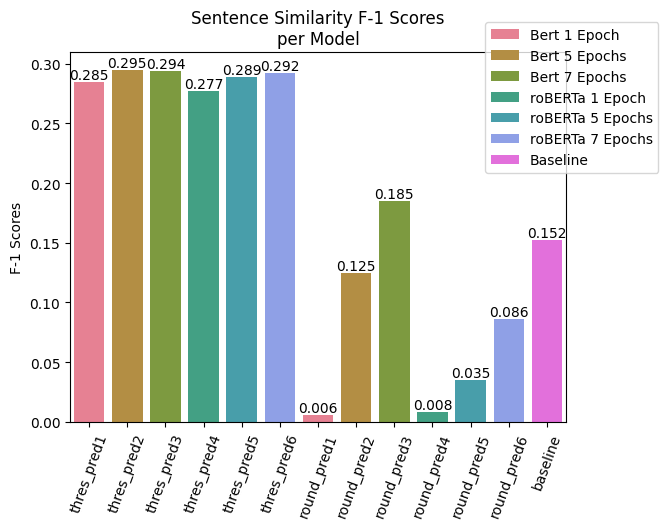

In [78]:
columns = ['thres_pred1','thres_pred2','thres_pred3','thres_pred4','thres_pred5','thres_pred6','round_pred1','round_pred2','round_pred3','round_pred4','round_pred5','round_pred6']
f1 = []
models = []

for x in columns:
    f1.append(round(f1_score(test_df['similarity'], test_df[x], average='binary'),3))
    if '1' in x:
        models.append('Bert 1 Epoch')
    elif '2' in x:
        models.append('Bert 5 Epochs')
    elif '3' in x:
        models.append('Bert 7 Epochs')
    elif '4' in x:
        models.append('roBERTa 1 Epoch')
    elif '5' in x:
        models.append('roBERTa 5 Epochs')
    elif '6' in x:
        models.append('roBERTa 7 Epochs')

columns.append('baseline')
f1.append(.152)
models.append('Baseline')

ax=sns.barplot(x=columns,y=f1,hue=models)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Sentence Similarity F-1 Scores\nper Model')
plt.xticks(rotation=70)
plt.legend(bbox_to_anchor=(1.2, 1.1), bbox_transform=ax.transAxes)
_=plt.ylabel('F-1 Scores')

As shown above, using a custom threshold instead of rounding the cosine similarity is a significantly better than simply rounding the similarity. 